In [2]:
#Loading the data set
import pandas as pd
file_path="1952.xls"
religions = pd.read_excel(file_path)
print(religions.head())

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
   CaseID$          CNAME  STCODE  CCODE  TOTPOP  TOTMEMB  TOTCHUR  SDA_M  \
0       33       Hale, AL       1     65   20832     5145       52      0   
1       34      Henry, AL       1     67   18674     4773       31      0   
2       35    Houston, AL       1     69   46522    19420       88     87   
3       36    Jackson, AL       1     71   38998     9030       82    110   
4       37  Jefferson, AL       1     73  558928   212326      595    991   

   SDA_C  AOG_M  ...  UCHRC_M  UCHRC_C  UCA_M  UCA_C  VEDS_M  VEDS_C  VLNTR_M  \
0      0      0  ...        0        0      0      0       0       0        0   
1      0     23  ...        0        0      0      0       0       0        0   
2      2    379  ...        0        0      0      0       0       0        0   
3   

In [3]:
print(religions.describe())

           CaseID$       STCODE        CCODE        TOTPOP       TOTMEMB  \
count  3075.000000  3075.000000  3075.000000  3.075000e+03  3.075000e+03   
mean   1538.000000    30.373984    96.128130  4.898718e+04  2.410584e+04   
std     887.820365    14.885946    86.417379  1.698913e+05  9.496974e+04   
min       1.000000     1.000000     1.000000  5.200000e+01  0.000000e+00   
25%     769.500000    19.000000    35.000000  1.000850e+04  4.006500e+03   
50%    1538.000000    29.000000    77.000000  1.876000e+04  7.905000e+03   
75%    2306.500000    45.000000   131.000000  3.584500e+04  1.589350e+04   
max    3075.000000    56.000000   510.000000  4.508792e+06  2.685524e+06   

           TOTCHUR         SDA_M        SDA_C         AOG_M        AOG_C  ...  \
count  3075.000000   3075.000000  3075.000000   3075.000000  3075.000000  ...   
mean     59.465366     82.131382     0.909268    149.351545     2.323252  ...   
std      80.284820    378.736159     1.873668    451.966070     4.806493

The dataset refers to the distribution of religious groups in the United States in the year 1952. There are 49 different states listed in contrast to the 52 current states.
The basic attributes of the data set are the following:
- Id numbers for 49 of the 52 US states (STCODE)
- Id numbers for each county which belongs in one of the 49 out of the 52 US states (CCODE)
- The name of the corresponding county (CNAME)
- The total population of each county as a continues value (TOTPOP) ranging between 3 thousands and 4.5 million, which indicates   a high variance in county size.
- The total total number of registered church members in each county (TOTMEMB)
- The total number of churches in each county (TOTCHUR)
- 114 features that represent the number of religious followers for the 114 different religions that are listed in the US in       that period. The corresponding attributes are following the pattern: [Religion_acronym]_M (which stands for number of           members)
- Another 114 features that represent the number of churches in a specific county for each of the 114 different religions that     are listed in the US in that period. The corresponding attributes are following the pattern: [Religion_acronym]_C (which         stands for number of churces)

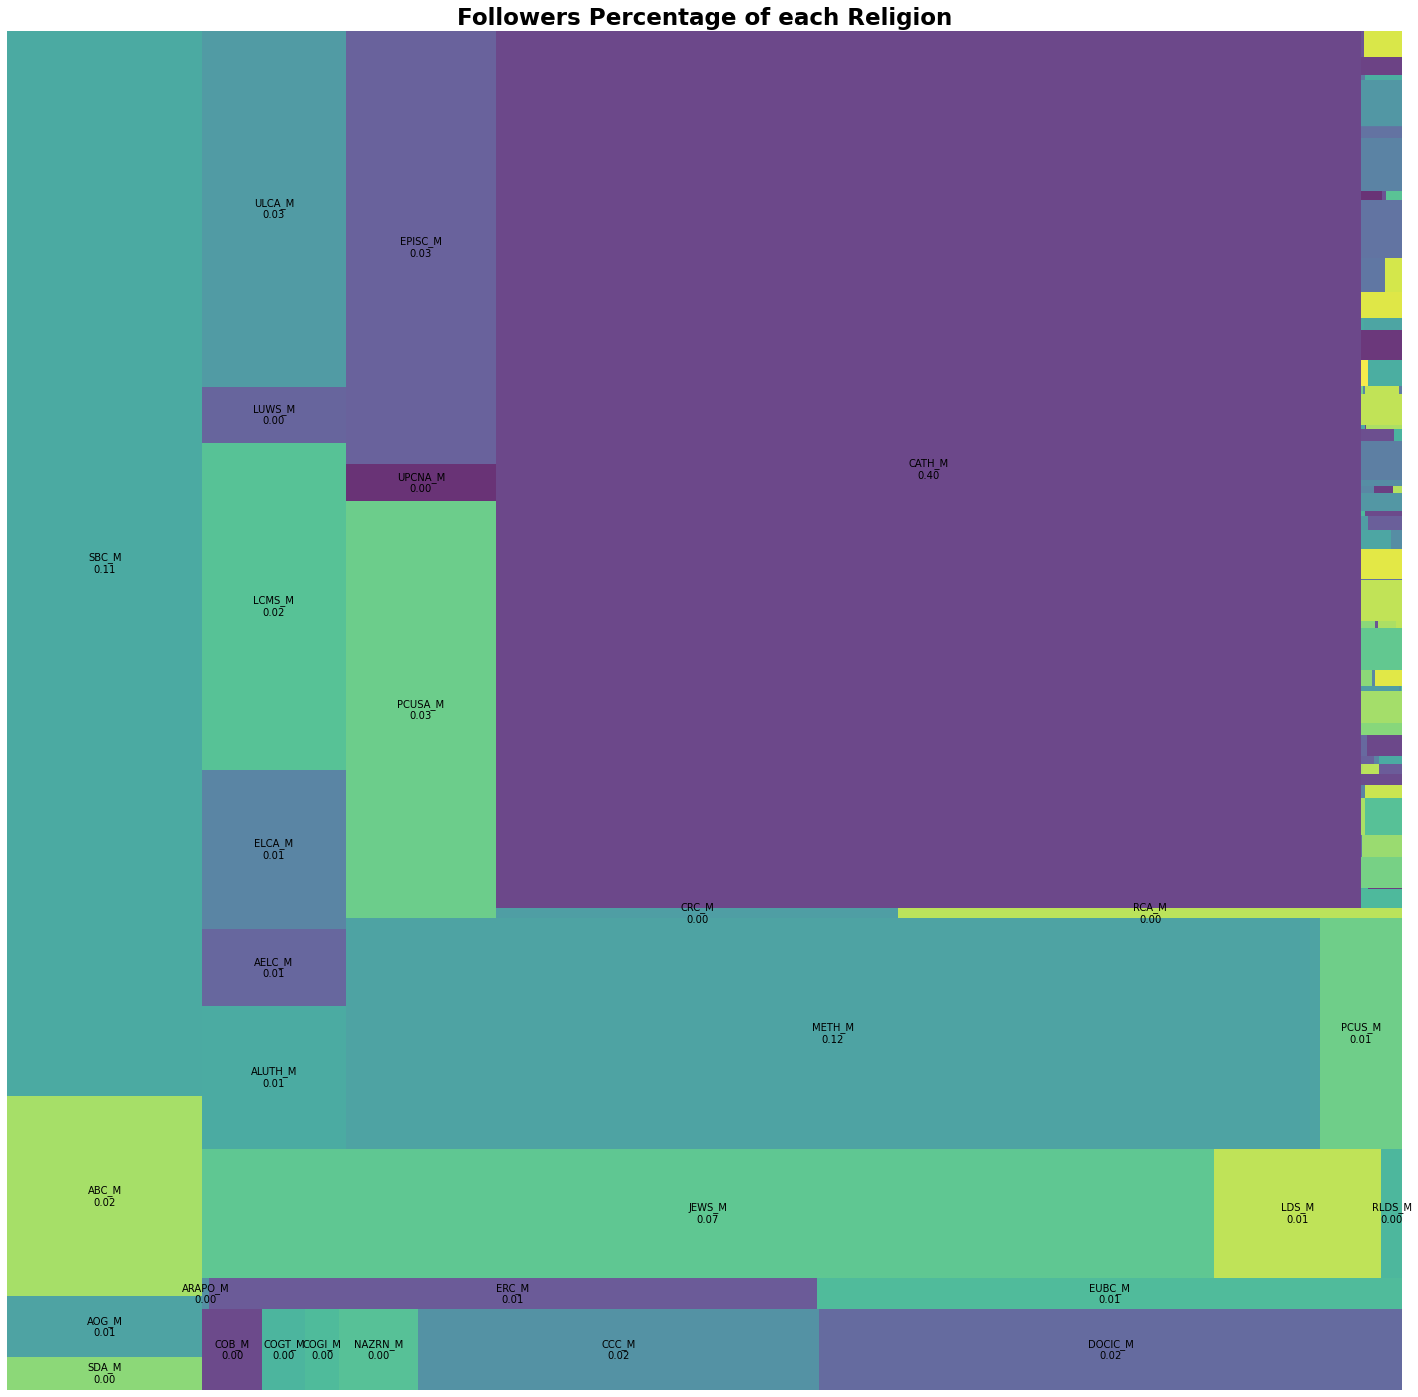

In [31]:
#Plot the total number of followers for each religion
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import squarify

religion_freq = religions.drop(labels=['CaseID$','CNAME','STCODE','CCODE','TOTPOP','TOTMEMB','TOTCHUR'],axis=1)
religion_summary = religion_freq.drop([x for x in religion_freq.columns if x.endswith('_C')], 1)
religion_summary = religion_summary.sum(axis=0).reset_index(name='Followers')
religion_summary = religion_summary.rename({'index': 'Religion'}, axis=1)


s = religion_summary[religion_summary['Followers']>0]
s = s.set_index('Religion',drop=True)
s_len = s / s.sum()

pl1 = pd.concat([s, s_len], axis=1).set_axis(['Religion','pct'], axis=1, inplace=False)
labels = ["%s\n%.2f" % (label) for label in zip(pl1.index, pl1.pct)]
fig, ax = plt.subplots(1, figsize = (25,25))
squarify.plot(sizes=pl1['pct'],
              label=labels[:30],
              alpha=.8 )
plt.title("Followers Percentage of each Religion",fontsize=23,fontweight="bold")
plt.axis('off')
plt.show()



The roman catholic followers comprise 40% of the religious followers, while the Methodist Churce comes second with 12% and the Southern Baptist Convention is 3rd with 11%.

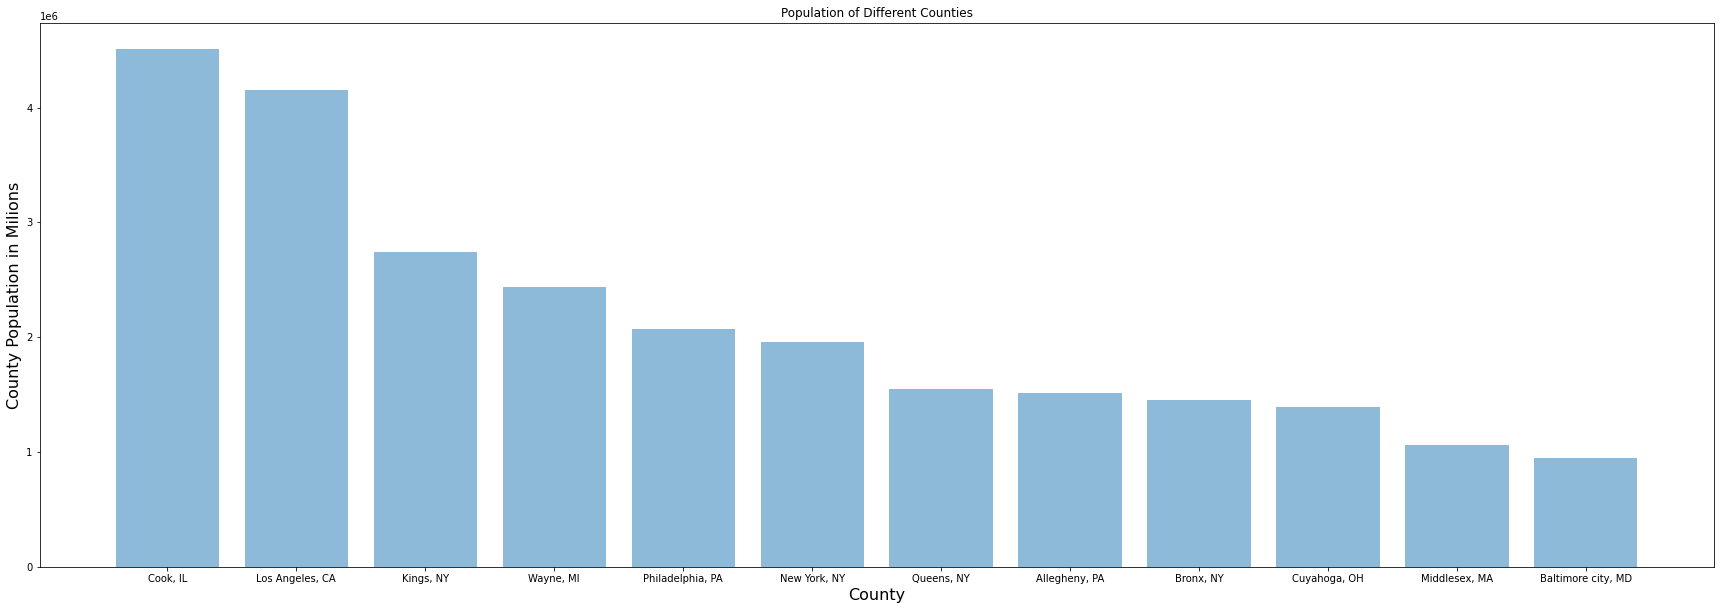

In [32]:
plt.figure(figsize=(30,10))
most_population = religions.sort_values('TOTPOP',ascending=False).iloc[0:12,4].values.tolist()
high_pop_counties = religions.sort_values('TOTPOP',ascending=False).iloc[0:12,1].values.tolist()

plt.bar(high_pop_counties,most_population, align='center', alpha=0.5)
plt.ylabel('Usage')
plt.title('Population of Different Counties')
plt.xlabel('County',fontsize=16)
plt.ylabel('County Population in Milions',fontsize=16)
plt.show()


In [38]:
#Creating a map of the percentage of religious followers per county
import os
from urllib.request import urlopen
import json
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

religions['STATE']=religions['CNAME'].str[-2:]
#Population at State level (year wise)
pop_state = religions.groupby(by=['STATE']).agg({'TOTPOP':sum}).reset_index()

adh_state = religions.groupby(by=['STATE']).agg({'TOTMEMB':sum}).reset_index()
adh_state = pd.merge(adh_state, pop_state[['STATE', 'TOTPOP']], left_on='STATE', right_on='STATE', how='inner')
adh_state['PER_ADH'] = np.round(adh_state['TOTMEMB']/adh_state['TOTPOP']*100,decimals=1)
print(adh_state.head())

fig1 = px.choropleth(adh_state, locations=adh_state['STATE'], locationmode="USA-states",
                     color='PER_ADH',color_continuous_scale="inferno",
                     range_color=(0, 100),scope="usa",labels={'PER_ADH':'% of Adherents'},#hover_name='State Name',
                     #hover_data={'STATEAB':False,'State Name':False,'ADHERENT':False,'TOTPOP':False,'PER_ADH':True}
                    )
fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig1.show()

  STATE  TOTMEMB    TOTPOP  PER_ADH
0    AL  1046460   3061743     34.2
1    AR   598593   1909511     31.3
2    AZ   336938    749587     44.9
3    CA  4306690  10586223     40.7
4    CO   550993   1325089     41.6


According to the map, the state of Road Island  has the highest percentage of religious followers, while the state of Utah comes second and the state of Massachusetts is third.

- Which are the counties with the highest per person ratio of Orthodox Christian members?
We have identified 4 different religons of Orthodox Christians: GRKAD_M
GRKAD:Greek Orthodox Archdiocese of North and South America
BEOC:Bulgarian Eastern Orthodox Church
ACROC:American Carpatho-Russian Orthodox Greek Catholic Church
ARAPO:Armenian Apostolic Orthodox Church of America

We will add up the followers for all of these religions for every county and divide the sum by the total population of the county

In [33]:
religions_ortho = religions[['CNAME','GRKAD_M','BEOC_M','ACROC_M','ARAPO_M','TOTPOP']]
religions_ortho['Orthodox_Proportion']= (religions['GRKAD_M'] + religions['BEOC_M']
+religions['ACROC_M']+religions['ARAPO_M'])/religions['TOTPOP']

most_orthodox=religions_ortho.sort_values('Orthodox_Proportion',ascending=False)

#Printing the 10 counties with the highest percentage of Orthodox Christians
print(most_orthodox[['CNAME','Orthodox_Proportion']].head(10))



               CNAME  Orthodox_Proportion
164     Cherokee, AL             0.011342
618      Madison, IL             0.002304
133       Fresno, CA             0.002275
3030      Racine, WI             0.001944
2278  Providence, RI             0.001734
662        Allen, IN             0.001361
2053      Lorain, OH             0.001350
1833  Rensselaer, NY             0.001297
1207     Calhoun, MI             0.001242
2084    Trumbull, OH             0.000944


C:\Users\Ires\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


- Can you find the 3 most extreme (outlier) counties with respect to the distribution of their churches across religions?
The answer to this question depends on what constitutes extreme distribution of churches across religions. We considered the counties where one religion is absolutely dominant over the others as outliers. In these counties, most of the churches  belong to that dominant religion. In order to identify this counties, we will use the coefficient of variation (CoV). 

Specifically, for each county, we will identify the count of churches for all religions that are present in a list (zero count churches will be excluded). We will then calculate the coefficient of variation (CoV) of the list. We expect counties with polarized distribution of churches that highly leans towards one dominant religion to have higher values of CoV. On the contrary counties with a uniform distribution of churches, such as Sterling, TX, which has 3 chourches distributed evenly over 3 religions, will have a coefficient of variation equal to 0.

In [34]:
churches = religions[[x for x in religions.columns if x.endswith('_C') or x.endswith('_C2')]]
religions['Coefficient_Variation']=0.0  #We initialize CoV at the value 0 for all counties

# We loop over all counties, create a list with non-zero count churches in each county and calculate the CoV
for row in churches.index:
    non_zero_churches = []
    for column in churches.columns:
        if churches.at[row,column] != 0:     
            non_zero_churches.append(churches.at[row,column])       
    if non_zero_churches:   # There are counties with no churches at all. Their CoV value will remain 0
        non_zero_np = np.array(non_zero_churches)
        religions.at[row,'Coefficient_Variation']=float(non_zero_np.std()/non_zero_np.mean())


# Printing the CoV for each county sorted in decending order
#outlier_counties = religions.sort_values('Coefficient_Variation',ascending=False)[['CNAME','Coefficient_Variation']].reset_index(drop=True)
outlier_counties = religions.sort_values('Coefficient_Variation',ascending=False).reset_index(drop=True)
#print(religions.sort_values('Coefficient_Variation',ascending=False)[['CNAME','Coefficient_Variation']])
print(outlier_counties[['CNAME','Coefficient_Variation']])
    

                              CNAME  Coefficient_Variation
0                        Sussex, DE               3.243143
1                      Wicomico, MD               2.701829
2                          Kent, DE               2.592924
3                        Wilkes, NC               2.531820
4                          Knox, TN               2.489706
...                             ...                    ...
3070                   Sterling, TX               0.000000
3071                     Sutton, TX               0.000000
3072                    Quitman, GA               0.000000
3073                     Zapata, TX               0.000000
3074  Yellowstone National Park, WY               0.000000

[3075 rows x 2 columns]


In [29]:
# The three most extreme outliers are 'Sussex, DE', 'Wicomico, MD' and 'Kent, DE'. We will plot the 
# distribution of churches across religions for these 3 counties
 
for row in outlier_counties.iloc[0:3,:].index:
    non_zero_churches = []
    for column in outlier_counties[[x for x in religions.columns if x.endswith('_C') or x.endswith('_C2')]].columns:
        if outlier_counties.at[row,column] != 0:
            non_zero_churches.append(outlier_counties.at[row,column])      
    print(outlier_counties.at[row,'CNAME'])
    print(non_zero_churches)


Sussex, DE
[2, 1, 1, 1, 4, 1, 2, 1, 1, 158, 8, 10, 1, 1, 1, 1, 1, 8, 1]
Wicomico, MD
[1, 2, 1, 1, 1, 2, 1, 59, 1, 4, 1, 1, 1, 1]
Kent, DE
[4, 1, 1, 5, 2, 1, 1, 75, 2, 5, 3, 1, 1, 4, 1, 2]


The results of the analysis are aligned with the initial thought that higher CoV results in a strongly polarized distribution of churches within the specific county.

- Where would you create a cross-religion center of discussion between religions to maximize its impact? Support the proposal based on data analysis results.
There are two different ways to approach this matter. We could either establish the cross-religion center in a county with a strongly polarized distribution of churches in order to aleviate the dominance of a single religion, or in a county where a very large number of different religions co-exist in order to help religious followers to understand the beliefs of as many religions as possible.
In the first case, we would establish the cross-religion center in 'Sussex, DE' where the Methodist Churce is absolutely dominant with 158 established churches.
In the second case, we would establish the center in the county with the maximum number of different co-existing religions.

In [35]:
religions['Different_Religions']=0.0  #We initialize number of Different Religions at the value 0 for all counties

# We loop over all counties, create a list with non-zero count churches in each county and calculate the length of the list
for row in churches.index:
    non_zero_churches = []
    for column in churches.columns:
        if churches.at[row,column] != 0:     
            non_zero_churches.append(churches.at[row,column])    
    religions.at[row,'Different_Religions']=len(non_zero_churches)
    
# Print the counties sorted by the number of different localy co-existing religions in decending order    
print(religions[['CNAME','Coefficient_Variation','Different_Religions']].sort_values('Different_Religions',ascending=False))

                              CNAME  Coefficient_Variation  \
172                 Los Angeles, CA               1.637532   
574                        Cook, IL               2.154832   
1276                      Wayne, MI               1.908164   
2024                   Cuyahoga, OH               1.946210   
2197                  Multnomah, OR               1.210128   
...                             ...                    ...   
2759                       Rich, UT               0.000000   
2757                     Morgan, UT               0.000000   
2755                       Kane, UT               0.000000   
2751                   Garfield, UT               0.000000   
3074  Yellowstone National Park, WY               0.000000   

      Different_Religions  
172                  70.0  
574                  66.0  
1276                 61.0  
2024                 53.0  
2197                 51.0  
...                   ...  
2759                  0.0  
2757                  0.0  
275

Based on our results, 'Los Angeles, CA' has the largest number of different religions, equal to 70. In that regard, it would be our first choice to create a cross-religion center of discussion that brings together 70 different religions. However, if we also take the CoV into consideration, 'Cook, IL' might  be a slightly better choice. There are 66 different religions in that county, while the higher value of the CoV indicates that the religions are distributed non - homogenously and that a dominant religion exists in the area. Consequently, we could hit two birds with one stone by establishing a cross-religion center there, which would initiate conversations between 66 different religions and also help aliviate the dominance of the roman catholic church in the region. 